<a href="https://colab.research.google.com/github/livjab/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

In [35]:
#data exploration

train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


"Violations" feature causes leakage becasue the results of the number of violations occurs at the same time as the inspection passes or fails. 

In [36]:
train["State"].value_counts()

IL    51906
Name: State, dtype: int64

In [0]:
# "Violations" would cause leakage and should not be used
# "State" is the same for every entry and is not helpful

train = train.drop(columns=["State", "Violations"])
test = test.drop(columns=["State", "Violations"])

In [0]:
# selecting target and features to use for model

y_train = train["Fail"] == 1
X_train = train.drop(columns=["Fail"])

y_test = test["Fail"] == 1
X_test = test.drop(columns=["Fail"])

In [39]:
X_train.isnull().sum()

Inspection ID        0
DBA Name             0
AKA Name           623
License #            5
Facility Type      224
Risk                12
Address              0
City                53
Zip                 26
Inspection Date      0
Inspection Type      1
Latitude           198
Longitude          198
Location           198
dtype: int64

In [40]:
!pip install category_encoders

In [0]:
# make a pipeline for preprocessing
# start with ordinal encoding for all categorical data
# add simple imputer for nulls
# and then scale with standard scaler

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

preprocessor = make_pipeline(ce.OrdinalEncoder(), 
                             StandardScaler(), 
                             SimpleImputer())
X_train = preprocessor.fit_transform(X_train)

X_train = pd.DataFrame(X_train)


In [72]:
# fitting a random forest model

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

scores = cross_validate(RandomForestClassifier(max_depth=5, n_estimators=100), 
                        X_train, 
                        y_train, 
                        scoring="roc_auc",
                        cv=3, 
                        return_train_score=True, 
                        return_estimator=True)
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,3.833824,0.131105,"(DecisionTreeClassifier(class_weight=None, cri...",0.680477,0.703544
1,3.834558,0.124022,"(DecisionTreeClassifier(class_weight=None, cri...",0.682972,0.700089
2,3.827459,0.130577,"(DecisionTreeClassifier(class_weight=None, cri...",0.685247,0.698975


In [73]:
print("ROC AUC Cross Validation Score:", scores["test_score"].mean())

ROC AUC Cross Validation Score: 0.6828985311803061


In [61]:
# use random search to find best parameters

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 5, 6]
}

search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_distributions, 
    n_iter=9, 
    cv=3, 
    scoring="roc_auc", 
    verbose=10, 
    return_train_score=True)

search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, max_depth=4, score=0.6730114085549883, total=   3.8s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, score=0.6759275876633415, total=   2.5s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, score=0.6763935085801869, total=   2.5s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6741386816115323, total=   4.8s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6763108374663085, total=   4.8s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6801801904579438, total=   4.8s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.1s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.673164332924467, total=   7.2s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.6764348920346429, total=   7.3s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.7s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.6797566109458888, total=   7.2s
[CV] n_estimators=100, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.5s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, score=0.6802493875711598, total=   3.0s
[CV] n_estimators=100, max_depth=5 ...................................
[CV]  n_estimators=100, max_depth=5, score=0.6862493893066617, total=   2.9s
[CV] n_estimators=100, max_depth=5 ...................................
[CV]  n_estimators=100, max_depth=5, score=0.688271848887689, total=   3.0s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.6822535117578675, total=   5.9s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.6863484413712623, total=   5.8s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.6886092302869061, total=   5.7s
[CV] n_estimators=300, max_depth=5 ...................................
[CV]  n_estimators=300, max_depth=5, score=0.6825687288993277, total=   8.8s
[CV] n_estimators=300, max_depth=5 .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=9, n_jobs=None,
          param_distributions={'n_estimators': [100, 200, 300], 'max_depth': [4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [63]:
print('Cross Validation ROC_AUC:', search.best_score_)

Cross Validation ROC_AUC: 0.6910549079114173


In [65]:
from sklearn.metrics import roc_auc_score

best = search.best_estimator_
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6963621275115393


In [82]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (0.82)


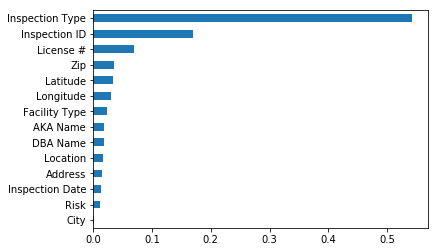

In [84]:
# visualization for feature importances

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
top_n.plot.barh();

What does Gradient Descent seek to minimize?
- Gradient descent seeks to minimize cost or loss


What is the "Learning Rate" and what is its function?
- The Learning Rate determines how fast or slow we move to the optimal values. It is a hyper-parameter  for the size of the steps used to move towards the optimal value.
